# Imports

In [1]:
import pandas as pd
import numpy as np
import cv2
import os
from PIL import Image, ImageDraw, ImageFont
import opencc
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

2024-07-26 08:57:36.680037: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 08:57:36.699745: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 08:57:36.705782: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-26 08:57:36.720807: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-26 08:57:37.586204: W tensorflow/compiler/tf2

# Load Raw Data

In [2]:
path = '/home/andrew/Picture-to-Pinyin'

# Import csv data
df = pd.read_csv(f'{path}/chinese_chars.csv')
df.sort_values(by=['stroke_count', 'pinyin'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,stroke_count,character,pinyin
0,1,一,yī
1,1,乙,yǐ
2,2,卜,bo
3,2,八,bā
4,2,匕,bǐ


# Create PNGs

In [3]:
# Creates a 'dim' * 'dim' PNG image out of 'char' and saves to 'file_path'
def create_PNG(char, file_path, dim=64):
    img = Image.new("L", (dim, dim), 255)
    draw = ImageDraw.Draw(img)

    font_path = f'{path}/font_huawenkaiti.ttf'
    font = font = ImageFont.truetype(font_path, size=dim*240//256)

    # Uses PIL to draw 'char' in the center
    text_bbox = draw.textbbox((0, 0), char, font)
    text_width = text_bbox[2] - text_bbox[0]
    text_x = (dim - text_width) // 2
    text_y = -dim*40//256
    draw.text((text_x, text_y), char, font=font, fill=0)
    
    img.save(file_path)
    
if not os.path.exists(f'{path}/char_dataset'):
    os.makedirs(f'{path}/char_dataset')

    # Loop through all chars in df
    for index, entry in df.iterrows():
        char = entry['character']
        traditional_char = opencc.OpenCC('s2t').convert(char)
        
        # Save only stroke_count, pinyin, and traditional_char for later use
        stroke_count = entry['stroke_count']
        pinyin = entry['pinyin']
        file_path = f'{path}/char_dataset/{index}_{stroke_count}_{traditional_char}_{pinyin}.png'
        create_PNG(traditional_char, file_path, 128)
        
        print(f"\rProcessed {index+1}/{df.shape[0]} characters", end='')

# Process Data / Create Labels

In [4]:
# Strips tone from syllable
tone_to_letter = {
    'ā': 'a', 'á': 'a', 'ǎ': 'a', 'à': 'a',
    'ē': 'e', 'é': 'e', 'ě': 'e', 'è': 'e',
    'ī': 'i', 'í': 'i', 'ǐ': 'i', 'ì': 'i',
    'ō': 'o', 'ó': 'o', 'ǒ': 'o', 'ò': 'o',
    'ū': 'u', 'ú': 'u', 'ǔ': 'u', 'ù': 'u',
    'ǖ': 'ü', 'ǘ': 'ü', 'ǚ': 'ü', 'ǜ': 'ü'
}

# Isolates tone from syllable
tone_to_number = {
    'ā': '1', 'á': '2', 'ǎ': '3', 'à': '4',
    'ē': '1', 'é': '2', 'ě': '3', 'è': '4',
    'ī': '1', 'í': '2', 'ǐ': '3', 'ì': '4',
    'ō': '1', 'ó': '2', 'ǒ': '3', 'ò': '4',
    'ū': '1', 'ú': '2', 'ǔ': '3', 'ù': '4',
    'ǖ': '1', 'ǘ': '2', 'ǚ': '3', 'ǜ': '4'
}

# Returns base syllable and tone number
def convert_pinyin(pinyin):
    base_syllable = ''
    tone_number = ''
    
    for char in pinyin:
        if char in tone_to_number:
            tone_number = tone_to_number[char]
            base_syllable += tone_to_letter[char]
        else:
            base_syllable += char
    
    return base_syllable, tone_number

# Returns index of file, used for sorting by stroke_count
def get_index(filename):
    return int(filename.split('_')[0])

# Loads processed images and creates labels
def load_data(image_folder):
    all_images = []
    all_labels = []
    filenames = sorted(os.listdir(image_folder), key=get_index)
    
    for filename in filenames:
        img_path = os.path.join(image_folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img / 255.0 # Normalize
        
        pinyin = filename.split('_')[-1].split('.')[0]
        pinyin_string, _ = convert_pinyin(pinyin) # Train model to identify pinyin without tone
        
        all_images.append(img)
        all_labels.append(pinyin_string)
            
    return np.array(all_images), np.array(all_labels)


def split_data(images, labels, val_split=0.2, test_split=0.2):
    size = len(images)
    val_end = int(size*(1-test_split))
    train_end = int(val_end*(1-val_split))
    
    train_images = images[:train_end]
    train_labels = labels[:train_end]
    val_images = images[train_end:val_end]
    val_labels = labels[train_end:val_end]
    test_images = images[val_end:]
    test_labels = labels[val_end:]
    
    return train_images, train_labels, val_images, val_labels, test_images, test_labels

In [5]:
images, labels = load_data(f'{path}/char_dataset')

# Encodes pinyin strings as integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

train_images, train_labels, val_images, val_labels, test_images, test_labels = split_data(images, labels)
print(f'Train: {train_images.shape[0]}\nVal: {val_images.shape[0]}\nTest: {test_images.shape[0]}')

Train: 7079
Val: 1770
Test: 2213


# Augment Data

In [6]:
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest'
)

if len(train_images.shape) == 3:
    train_images = np.expand_dims(train_images, axis=-1)

datagen.fit(train_images)
generator = datagen.flow(train_images, train_labels, batch_size=32)

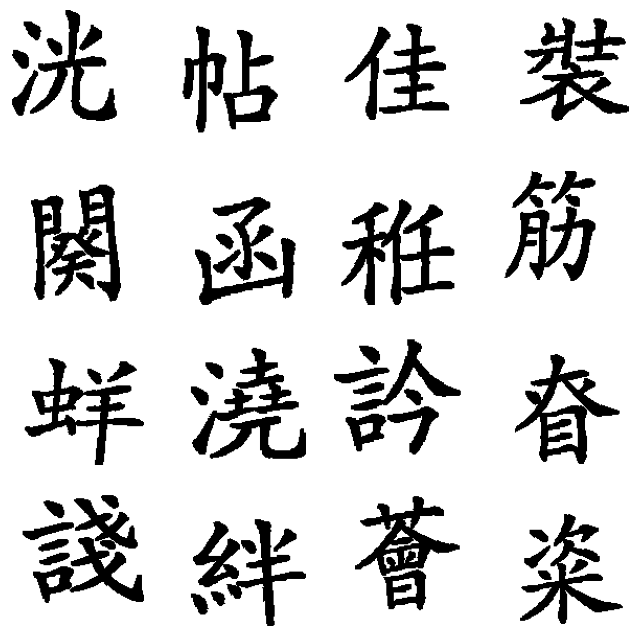

In [7]:
import matplotlib.pyplot as plt

# Create a generator
augmented_images = datagen.flow(train_images, batch_size=1)

num_images = 16
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
axes = axes.flatten()
for i in range(num_images):
    img = next(augmented_images)[0].astype('uint8')
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].axis('off')
plt.show()

# Train Model

/home/andrew/ITRI-LungCancer/env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


2024-07-26 08:57:41.549779: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14793 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0001:00:00.0, compute capability: 7.5


/home/andrew/ITRI-LungCancer/env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1721984263.349595   40940 service.cc:146] XLA service 0x14b464001e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721984263.349641   40940 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-07-26 08:57:43.390406: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-26 08:57:43.591409: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
E0000 00:00:1721984

  6/222 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.0000e+00 - loss: 26.3999

I0000 00:00:1721984266.634861   40940 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 52/222 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.0042 - loss: 14.2176

E0000 00:00:1721984268.783815   40940 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1721984268.926515   40940 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


222/222 ━━━━━━━━━━━━━━━━━━━━ 22s 78ms/step - accuracy: 0.0090 - loss: 8.8885 - val_accuracy: 5.6497e-04 - val_loss: 23.9146
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.0147 - loss: 5.9520 - val_accuracy: 0.0096 - val_loss: 6.5090
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.0181 - loss: 5.9098 - val_accuracy: 0.0113 - val_loss: 5.9023
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.0141 - loss: 5.8724 - val_accuracy: 0.0113 - val_loss: 5.8774
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.0166 - loss: 5.8457 - val_accuracy: 0.0113 - val_loss: 5.8558
Epoch 6/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.0176 - loss: 5.8205 - val_accuracy: 0.0113 - val_loss: 5.8373
Epoch 7/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.0143 - loss: 5.8022 - val_accuracy: 0.0113 - val_loss: 5.8215
Epoch 8/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.0159 - loss: 5.7787 - val_ac

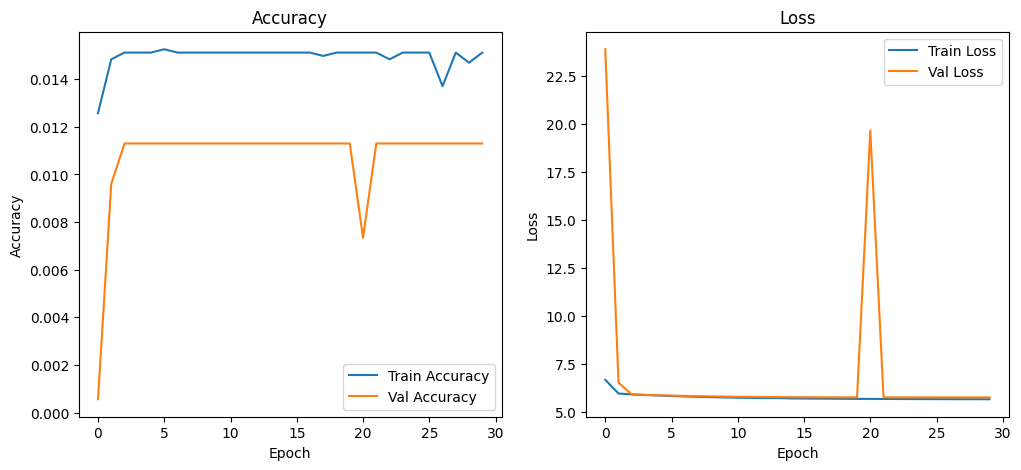

In [8]:
def create_cnn_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        # First Convolutional Block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        # Second Convolutional Block
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        # Third Convolutional Block
        # tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        # Flatten and Dense Layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=1e-3))
    return model

input_shape = (128, 128, 1)
num_classes = len(np.unique(labels))
model = create_cnn_model(input_shape, num_classes)

history = model.fit(
    # train_images, train_labels,
    generator,
    epochs=100,
    batch_size=512,
    validation_data=(val_images, val_labels),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluate

In [9]:
accuracy = model.evaluate(val_images, val_labels, verbose=0)[1]
print(f'Test accuracy: {accuracy:.2f}')
loss = model.evaluate(val_images, val_labels, verbose=0)[0]
print(f'Test loss: {loss:.2f}')

Test accuracy: 0.01
Test loss: 5.74


In [10]:
model.save(f'{path}/model.keras')

In [ ]:
def preprocess_image(image_path, target_size):
    # Load the image and resize it
    img = image.load_img(image_path, target_size=target_size, color_mode='grayscale')  # Adjust color_mode as needed
    img_array = image.img_to_array(img)
    
    # Normalize pixel values to [0, 1]
    img_array /= 255.0
    
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

image_path = '''
/home/andrew/Picture-to-Pinyin/char_dataset/9228_16_醒_xǐng.png
'''.strip()
input_shape = (128, 128)  # Adjust according to your model's input shape
processed_image = preprocess_image(image_path, target_size=input_shape)

# Make a prediction
model = tf.keras.models.load_model(f'{path}/model.keras')
predictions = model.predict(processed_image)

top_5_indices = np.argsort(predictions[0])[-5:][::-1]  # Indices of top 5 classes
top_5_probabilities = predictions[0][top_5_indices]
top_5_labels = [encoder.inverse_transform([i])[0] for i in top_5_indices]  # Convert indices to class labels

# Display results
for i in range(5):
    print(f"Class: {top_5_labels[i]}, Probability: {top_5_probabilities[i]:.4f}")

NameError: name 'image' is not defined